# Leveraging Unsupervised Learning Models for Clustering and Dimensionality Reduction From TensorFlow Hub and Kaggle

Here I explore and evaluate pre-trained models from Kaggle and TensorFlow Hub, considering the tradeoffs between various methods of unsupervised clustering and dimensionality reduction for interfacing with complex, high-dimensional datasets. 

### Imports

In [49]:
# --- imports ---
import os
import gc
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
from time import perf_counter
warnings.filterwarnings("ignore")

# preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    normalized_mutual_info_score, adjusted_rand_score
)
from sklearn.neighbors import NearestNeighbors
# plotting
import matplotlib.pyplot as plt
# TF
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [7]:
# --- set your local file paths here ---
MNIST_TRAIN_CSV = Path("train.csv")          
MALL_CSV        = Path("Mall_Customers.csv")  

### MNIST Preprocessing (Scaling pixels from 0 - 1, and including a subsequent standard scale on the resulting pixel arrays.

In [9]:
def load_mnist_from_csv(csv_path: Path):
    if not csv_path.exists():
        raise FileNotFoundError(
            f"Could not find {csv_path}. "
            "Place Kaggle's MNIST train.csv in your working directory."
        )
    df = pd.read_csv(csv_path)
    
    # Expect a 'label' column; everything else are pixels
    if "label" not in df.columns:
        raise ValueError("MNIST train.csv must contain a 'label' column.")
    
    y = df["label"].astype(int).to_numpy()
    X_pixels = df.drop(columns=["label"]).to_numpy(dtype=np.float32)

    # Safety checks
    if X_pixels.shape[1] != 784:
        raise ValueError(f"Expected 784 pixel columns, found {X_pixels.shape[1]}.")

    # Normalize to [0,1] for AE training; keep a standardized copy for clustering
    X01 = X_pixels / 255.0
    scaler = StandardScaler()
    Xscaled = scaler.fit_transform(X01)

    meta = {
        "n_samples": X01.shape[0],
        "n_features": X01.shape[1],
        "image_shape": (28, 28),
    }
    return X01, Xscaled, y, meta

X_mnist01, X_mnist_scaled, y_mnist, mnist_meta = load_mnist_from_csv(MNIST_TRAIN_CSV)
mnist_img_shape = mnist_meta["image_shape"]

print("MNIST loaded from CSV")
print("  X_mnist01 shape (normalized [0,1]):", X_mnist01.shape)
print("  X_mnist_scaled shape (standardized):", X_mnist_scaled.shape)
print("  y_mnist shape:", y_mnist.shape)
print("  image shape:", mnist_img_shape)

MNIST loaded from CSV
  X_mnist01 shape (normalized [0,1]): (42000, 784)
  X_mnist_scaled shape (standardized): (42000, 784)
  y_mnist shape: (42000,)
  image shape: (28, 28)


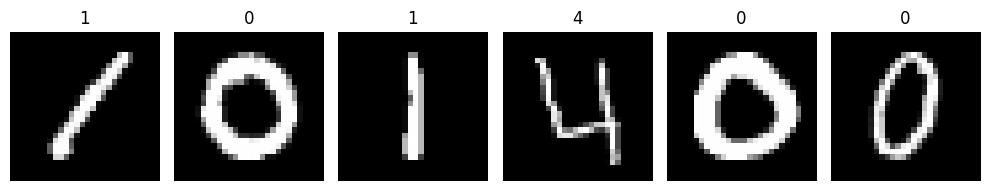

In [11]:
# Visual check of a few digits
n_show = 6
fig, axes = plt.subplots(1, n_show, figsize=(10, 2))
for i in range(n_show):
    img = (X_mnist01[i].reshape(mnist_img_shape))
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(int(y_mnist[i]))
    axes[i].axis("off")
plt.tight_layout()
plt.show()

Preprocessing of the MNIST dataset includes scaling every image of 28x28 pixels from 0 - 255 to 0 - 1, and then performing a seperate standard scaler step to support downstream clustering approaches like kNN and DBSCAN. Scaling the pixels to [0, 1] is useful for auto encoder input. Following this preprocessing we can observe we have 42,000 unique images now scaled to 28x28 with each pixel value falling between 0 and 1. 

### Mall Customer Preprocessing (OneHoteEncode Gender, imput missing numerical values using the median, and standard scale them)

In [24]:
def load_mall_customers(csv_path: Path):
    if not csv_path.exists():
        raise FileNotFoundError(
            f"Could not find {csv_path}. Download Kaggle's Mall Customers dataset "
            "and place 'Mall_Customers.csv' in your working directory."
        )
    df = pd.read_csv(csv_path)
    
    # Normalize column names to expected ones if necessary
    # (Some versions use 'Genre'—rename to 'Gender')
    if "Genre" in df.columns and "Gender" not in df.columns:
        df = df.rename(columns={"Genre": "Gender"})
    
    required = ["Gender", "Age", "Annual Income (k$)", "Spending Score (1-100)"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing expected columns: {missing}")

    df_small = df[required].copy()

    cat_cols = ["Gender"]
    num_cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

    preprocess = ColumnTransformer(
        transformers=[
            ("cat",
             OneHotEncoder(drop="if_binary", handle_unknown="ignore"),
             cat_cols),
            ("num",
             Pipeline(steps=[
                 ("imp", SimpleImputer(strategy="median")),
                 ("scaler", StandardScaler()),
             ]),
             num_cols),
        ],
        remainder="drop"
    )

    X = preprocess.fit_transform(df_small)

    # Build feature names
    ohe = preprocess.named_transformers_["cat"]
    cat_names = list(ohe.get_feature_names_out(cat_cols)) if hasattr(ohe, "get_feature_names_out") else cat_cols
    cust_feature_names = cat_names + num_cols

    return df_small, X, cust_feature_names

df_cust, X_cust, cust_feature_names = load_mall_customers(MALL_CSV)

print("Mall Customers loaded from CSV")
print("  df_cust shape (original selected columns):", df_cust.shape)
print("  X_cust shape (encoded+standardized):", X_cust.shape)
print("  feature names:", cust_feature_names)
df_cust.head()

Mall Customers loaded from CSV
  df_cust shape (original selected columns): (200, 4)
  X_cust shape (encoded+standardized): (200, 4)
  feature names: ['Gender_Male', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


The gender column has been OneHotEncoded to a binary variable capable of indicating gender, and age/income/score columns have been standard scaled. 

### PCA for both the MNIST and Mall Customer Datasets

In [32]:
# Choose PCA dimensionalities you want to compare later
MNIST_PCA_DIMS = [16, 32, 64, 100]
CUST_PCA_DIMS  = [2, 3]   # small tabular set; 2-3 comps are usually enough

# Fit PCA on MNIST (X_mnist_scaled)
mnist_pca_models = {}
mnist_pca_feats  = {}
for d in MNIST_PCA_DIMS:
    pca = PCA(n_components=d, random_state=42)
    X_pca = pca.fit_transform(X_mnist_scaled)
    mnist_pca_models[d] = pca
    mnist_pca_feats[d]  = X_pca
    evr = pca.explained_variance_ratio_.sum()
    print(f"[MNIST] PCA-{d:>3}D -> explained variance: {evr:.3f}")

# Fit PCA on Customers (X_cust)
cust_pca_models = {}
cust_pca_feats  = {}
for d in CUST_PCA_DIMS:
    pca = PCA(n_components=d, random_state=42)
    X_pca = pca.fit_transform(X_cust)
    cust_pca_models[d] = pca
    cust_pca_feats[d]  = X_pca
    evr = pca.explained_variance_ratio_.sum()
    print(f"[CUST ] PCA-{d:>3}D -> explained variance: {evr:.3f}")

[MNIST] PCA- 16D -> explained variance: 0.350
[MNIST] PCA- 32D -> explained variance: 0.470
[MNIST] PCA- 64D -> explained variance: 0.611
[MNIST] PCA-100D -> explained variance: 0.712
[CUST ] PCA-  2D -> explained variance: 0.718
[CUST ] PCA-  3D -> explained variance: 0.925


### Autoendocer for MNIST Dataset

In [39]:
# --- Tiny dense autoencoder for MNIST (on X_mnist01) ---
# Produces latent features you can cluster on (e.g., 16D/32D)
def build_dense_autoencoder(input_dim: int, latent_dim: int = 16):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(512, activation="relu")(inp)
    x = layers.Dense(256, activation="relu")(x)
    z = layers.Dense(latent_dim, name="latent")(x)             # linear activation for latent
    x = layers.Dense(256, activation="relu")(z)
    x = layers.Dense(512, activation="relu")(x)
    out = layers.Dense(input_dim, activation="sigmoid")(x)     # because inputs are in [0,1]
    ae = keras.Model(inp, out, name=f"AE_{latent_dim}d")
    enc = keras.Model(inp, z, name=f"Encoder_{latent_dim}d")
    return ae, enc

def train_autoencoder(X01, latent_dim=16, max_epochs=50, batch_size=256, verbose=1):
    tf.random.set_seed(42)
    ae, enc = build_dense_autoencoder(X01.shape[1], latent_dim=latent_dim)
    ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    hist = ae.fit(
        X01, X01,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[es],
        verbose=verbose
    )
    Z = enc.predict(X01, batch_size=batch_size, verbose=0)
    recon = ae.predict(X01[:1024], batch_size=batch_size, verbose=0)  # quick sample for loss check
    recon_mse = np.mean((X01[:1024] - recon) ** 2)
    return ae, enc, Z, hist.history, recon_mse

# Train two AE variants to compare (16D, 32D)
AE_LATENTS = [16, 32]
mnist_ae_latents = {}
mnist_encoders   = {}
mnist_histories  = {}
mnist_recon_mse  = {}

for ld in AE_LATENTS:
    print(f"\nTraining AE with latent_dim={ld} ...")
    ae, enc, Z, hist, mse = train_autoencoder(X_mnist01, latent_dim=ld, max_epochs=50, batch_size=256, verbose=0)
    mnist_encoders[ld]   = enc
    mnist_ae_latents[ld] = Z
    mnist_histories[ld]  = hist
    mnist_recon_mse[ld]  = mse
    print(f"  AE-{ld}D latent shape: {Z.shape} | sample reconstruction MSE (n=1024): {mse:.5f}")



Training AE with latent_dim=16 ...


2025-10-01 10:53:39.101260: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-10-01 10:53:39.101348: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-10-01 10:53:39.101359: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-10-01 10:53:39.101414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-01 10:53:39.101441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-10-01 10:53:40.014118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  AE-16D latent shape: (42000, 16) | sample reconstruction MSE (n=1024): 0.11266

Training AE with latent_dim=32 ...
  AE-32D latent shape: (42000, 32) | sample reconstruction MSE (n=1024): 0.12779


### Autoencoder for Customers dataset (likely overkill relative to PCA)

In [42]:
#Tiny AE for Customers (tabular) ---
# Input is already standardized/OHE as X_cust

def build_tabular_autoencoder(input_dim: int, latent_dim: int = 2):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(16, activation="relu")(inp)
    z = layers.Dense(latent_dim, name="latent")(x)
    x = layers.Dense(16, activation="relu")(z)
    out = layers.Dense(input_dim, activation=None)(x)  # MSE on standardized inputs
    ae = keras.Model(inp, out)
    enc = keras.Model(inp, z)
    return ae, enc

def train_tabular_autoencoder(X, latent_dim=2, max_epochs=200, batch_size=64, verbose=0):
    tf.random.set_seed(42)
    ae, enc = build_tabular_autoencoder(X.shape[1], latent_dim=latent_dim)
    ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    hist = ae.fit(
        X, X,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[es],
        verbose=verbose
    )
    Z = enc.predict(X, batch_size=batch_size, verbose=0)
    recon = ae.predict(X, batch_size=batch_size, verbose=0)
    recon_mse = float(np.mean((X - recon) ** 2))
    return ae, enc, Z, hist.history, recon_mse

print("\nTraining small AE for Customers (latent=2) ...")
cust_ae, cust_enc, Z_cust, hist_cust, mse_cust = train_tabular_autoencoder(X_cust, latent_dim=2)
print(f"Customers AE latent shape: {Z_cust.shape} | reconstruction MSE: {mse_cust:.5f}")


Training small AE for Customers (latent=2) ...
Customers AE latent shape: (200, 2) | reconstruction MSE: 0.32294


### Helper Functions for kMeans and DBSCAN evaluations

In [58]:
# ---------- metrics (with sampling) ----------
def safe_silhouette(X, labels, sample_size=10000, random_state=42):
    labs = np.unique(labels)
    if len(labs) <= 1:
        return np.nan
    try:
        # sample-based silhouette (huge speedup)
        return silhouette_score(X, labels, metric="euclidean",
                                sample_size=min(sample_size, len(X)),
                                random_state=random_state)
    except Exception:
        return np.nan

def compute_internal_metrics(X, labels, sample_size=10000):
    m = {}
    m["silhouette"] = safe_silhouette(X, labels, sample_size=sample_size)
    try: m["davies_bouldin"] = davies_bouldin_score(X, labels)
    except Exception: m["davies_bouldin"] = np.nan
    try: m["calinski_harabasz"] = calinski_harabasz_score(X, labels)
    except Exception: m["calinski_harabasz"] = np.nan
    return m

def compute_external_metrics(y_true, labels):
    m = {}
    try: m["NMI"] = normalized_mutual_info_score(y_true, labels)
    except Exception: m["NMI"] = np.nan
    try: m["ARI"] = adjusted_rand_score(y_true, labels)
    except Exception: m["ARI"] = np.nan
    return m

def stdz(X):
    return StandardScaler().fit_transform(X)

# ---------- quick K-Means (to rank spaces fast) ----------
def kmeans_silhouette(X, k, sample_size=10000, seed=42):
    km = KMeans(n_clusters=k, n_init=10, random_state=seed)
    labels = km.fit_predict(X)
    sil = safe_silhouette(X, labels, sample_size=sample_size, random_state=seed)
    return sil, labels

# ---------- pick top-N spaces by K-Means silhouette ----------
def select_spaces_for_dbscan(spaces, k=10, top_n=2):
    """
    spaces: list of (name, X) where X is already scaled
    returns: list of (name, X) sorted by KMeans silhouette desc, top_n kept
    """
    scored = []
    for name, X in spaces:
        sil, _ = kmeans_silhouette(X, k=k, sample_size=8000)
        scored.append((sil if sil==sil else -np.inf, name, X))
    scored.sort(reverse=True, key=lambda t: t[0])
    return [(name, X) for _, name, X in scored[:top_n]]

# ---------- fast eps guess from subsample ----------
def guess_eps_from_knn(X, min_samples=5, subsample=10000, lo=0.60, hi=0.90, pad=0.10):
    """
    Subsample X, compute kNN (k=min_samples) distances, use quantiles to set eps band.
    Returns (eps_lo, eps_hi).
    """
    n = len(X)
    idx = np.random.RandomState(42).choice(n, size=min(subsample, n), replace=False)
    Xs = X[idx]
    # kd_tree/ball_tree are efficient at <= ~50 dims (use euclidean)
    nn = NearestNeighbors(n_neighbors=min_samples, algorithm="ball_tree", leaf_size=40, n_jobs=-1)
    nn.fit(Xs)
    dists, _ = nn.kneighbors(Xs)
    kth = dists[:, -1]
    q_lo, q_hi = np.quantile(kth, [lo, hi])
    return max(1e-6, q_lo*(1-pad)), q_hi*(1+pad)

# ---------- single-run or tiny-grid DBSCAN using guessed eps ----------
def dbscan_quick(X, min_samples=5, eps=None, eps_band=None):
    """
    If eps is given -> single run. If eps_band=(lo,hi) -> run 3 trials in that band.
    """
    trials = []
    if eps is not None:
        trials = [eps]
    elif eps_band is not None:
        lo, hi = eps_band
        trials = [lo, (lo+hi)/2.0, hi]
    else:
        raise ValueError("Provide eps or eps_band")
    best = None
    for e in trials:
        t0 = perf_counter()
        labels = DBSCAN(eps=float(e), min_samples=int(min_samples),
                        metric='euclidean', algorithm='ball_tree',
                        leaf_size=40, n_jobs=-1).fit_predict(X)
        dt = perf_counter() - t0
        sil = safe_silhouette(X, labels, sample_size=8000)
        if (best is None) or ((sil==sil) and (sil > best["silhouette"])):
            best = {"eps": float(e), "min_samples": int(min_samples),
                    "labels": labels, "time": dt, "silhouette": sil}
    return best

### MNIST KMeans and DBSCAN across feature spaces

In [64]:
# Expect: X_mnist_scaled, y_mnist, mnist_pca_feats (dict), mnist_ae_latents (dict)
mnist_results = []

# --- Define feature spaces (all scaled) ---
spaces = []
# Raw standardized pixels (already scaled)
spaces.append(("MNIST-raw-std", X_mnist_scaled, "none"))

# PCA spaces (standardize PCA outputs too)
for d, Xp in mnist_pca_feats.items():
    spaces.append((f"MNIST-PCA{d}-std", stdz(Xp), f"PCA-{d}"))

# AE spaces (standardize latents)
HAS_MNIST_AE = 'mnist_ae_latents' in globals() and isinstance(mnist_ae_latents, dict) and len(mnist_ae_latents) > 0
if HAS_MNIST_AE:
    for ld, Z in mnist_ae_latents.items():
        spaces.append((f"MNIST-AE{ld}-std", stdz(Z), f"AE-{ld}"))

# Small utility to be compatible whether compute_internal_metrics takes sample_size or not
def _compute_internal(X, labels, sample_size=8000):
    try:
        return compute_internal_metrics(X, labels, sample_size=sample_size)
    except TypeError:
        return compute_internal_metrics(X, labels)

# --- 1) KMeans across ALL spaces (k=10), using sampled silhouette internally ---
K_DIGITS = 10
for name, Xs, tag in spaces:
    labels, t = run_kmeans(Xs, k=K_DIGITS, minibatch=False)
    m_int = _compute_internal(Xs, labels, sample_size=8000)
    m_ext = compute_external_metrics(y_mnist, labels)
    mnist_results.append({
        "Feature_Space": name,
        "Method": f"KMeans(k={K_DIGITS})",
        "Fit_Time_s": t,
        **m_int, **m_ext
    })

# --- 2) Select TOP-N spaces for DBSCAN via quick KMeans silhouette ranking ---
TOP_N_SPACES = 7  # tune to 1–3 depending on time budget
spaces_for_selection = [(name, Xs) for name, Xs, _ in spaces]
top_spaces = select_spaces_for_dbscan(spaces_for_selection, k=K_DIGITS, top_n=TOP_N_SPACES)
print("DBSCAN will run on:", [n for n, _ in top_spaces])

# --- 3) Fast DBSCAN on selected spaces: subsampled eps band + 3 trials ---
DBSCAN_MIN_SAMPLES = 5
SUBSAMPLE_FOR_KNN = 12000  # subsample size for eps band estimation; lower if still slow

for name, Xs in top_spaces:
    # Estimate a reasonable eps band from subsampled kNN distances
    eps_band = guess_eps_from_knn(
        Xs, min_samples=DBSCAN_MIN_SAMPLES, subsample=SUBSAMPLE_FOR_KNN,
        lo=0.60, hi=0.90, pad=0.10
    )
    # Try just 3 eps values in that band; pick best by sampled silhouette
    best = dbscan_quick(
        Xs, min_samples=DBSCAN_MIN_SAMPLES, eps_band=eps_band
    )

    labels = best["labels"]
    m_int = _compute_internal(Xs, labels, sample_size=8000)
    m_ext = compute_external_metrics(y_mnist, labels)
    mnist_results.append({
        "Feature_Space": name,
        "Method": f"DBSCAN(eps={best['eps']:.4f}, ms={best['min_samples']})",
        "Fit_Time_s": best["time"],
        **m_int, **m_ext
    })

# --- 4) Collate results ---
mnist_df = pd.DataFrame(mnist_results).sort_values(["Feature_Space","Method"]).reset_index(drop=True)
mnist_df

DBSCAN will run on: ['MNIST-AE32-std', 'MNIST-AE16-std', 'MNIST-PCA16-std', 'MNIST-PCA64-std', 'MNIST-raw-std', 'MNIST-PCA32-std', 'MNIST-PCA100-std']


,Feature_Space,Method,Fit_Time_s,silhouette,davies_bouldin,calinski_harabasz,NMI,ARI
0,MNIST-AE16-std,"DBSCAN(eps=0.9041, ms=5)",1.545315,-0.023168,1.899329,59.547901,0.002019,0.000052
1,MNIST-AE16-std,KMeans(k=10),2.852023,0.211665,1.228651,28006.065111,0.173249,0.090348
2,MNIST-AE32-std,"DBSCAN(eps=0.2848, ms=5)",0.227037,-0.200674,1.734830,76.923319,0.009375,0.000188
3,MNIST-AE32-std,KMeans(k=10),3.042286,0.343941,0.829484,35895.852292,0.169458,0.124190
4,MNIST-PCA100-std,"DBSCAN(eps=9.2670, ms=5)",44.456795,0.371181,3.205959,64.412320,0.006819,0.000189
5,MNIST-PCA100-std,KMeans(k=10),4.451275,-0.009193,3.575616,349.860343,0.314552,0.172776
6,MNIST-PCA16-std,"DBSCAN(eps=2.8653, ms=5)",8.185663,0.428244,2.376834,242.012744,0.002599,0.000078
7,MNIST-PCA16-std,KMeans(k=10),2.531696,0.104884,2.000510,2300.084894,0.415973,0.291133
8,MNIST-PCA32-std,"DBSCAN(eps=4.8487, ms=5)",16.217685,0.484579,2.341554,158.518645,0.004838,0.000140
9,MNIST-PCA32-std,KMeans(k=10),3.117630,-0.005042,2.916262,1068.014889,0.380821,0.243943


MNIST dataset results for raw dataset, 4x PCA sources and 2x AE sources

In [62]:
# Expect: X_cust, cust_pca_feats (dict), and optionally Z_cust from your tabular AE

cust_results = []

# --- Define spaces (all scaled) ---
cust_spaces = [("CUST-raw-std", X_cust, "none")]  # X_cust is already standardized post-OHE

for d, Xp in cust_pca_feats.items():
    cust_spaces.append((f"CUST-PCA{d}-std", stdz(Xp), f"PCA-{d}"))

HAS_CUST_AE = 'Z_cust' in globals()
if HAS_CUST_AE:
    cust_spaces.append((f"CUST-AE-std", stdz(Z_cust), "AE"))

# --- Compatibility wrappers (handles both "sample_size" and no-arg variants) ---
def _silhouette(X, labels, sample=1000):
    try:
        return safe_silhouette(X, labels, sample_size=min(sample, len(X)))
    except TypeError:
        return safe_silhouette(X, labels)

def _compute_internal(X, labels, sample=1000):
    try:
        return compute_internal_metrics(X, labels, sample_size=min(sample, len(X)))
    except TypeError:
        return compute_internal_metrics(X, labels)

# --- KMeans: choose k by sampled silhouette (2..10) ---
def best_k_by_silhouette(X, k_range=range(2, 11), sample=1000):
    best_k, best_sil, best_labels, best_time = None, -np.inf, None, np.nan
    for k in k_range:
        labels, t = run_kmeans(X, k=k, minibatch=False)
        sil = _silhouette(X, labels, sample=sample)
        score = -np.inf if (isinstance(sil, float) and np.isnan(sil)) else sil
        if score > best_sil:
            best_k, best_sil, best_labels, best_time = k, sil, labels, t
    return best_k, best_labels, best_time, best_sil

# --- Run KMeans on all customer subspaces ---
for name, Xs, tag in cust_spaces:
    k, labels, t, sil = best_k_by_silhouette(Xs, range(2, 11), sample=1000)
    m_int = _compute_internal(Xs, labels, sample=1000)
    cust_results.append({
        "Feature_Space": name,
        "Method": f"KMeans(k={k})",
        "Fit_Time_s": t,
        **m_int  # no external metrics (no ground truth)
    })

# --- DBSCAN on ALL subspaces (fast eps-band + 3 trials) ---
DBSCAN_MIN_SAMPLES = 5
SUBSAMPLE_FOR_KNN  = min(2000, len(X_cust))  # tiny dataset → small subsample is fine

for name, Xs, tag in cust_spaces:
    # 1) Estimate eps band from a subsample (cheap and robust)
    eps_lo, eps_hi = guess_eps_from_knn(
        Xs, min_samples=DBSCAN_MIN_SAMPLES,
        subsample=SUBSAMPLE_FOR_KNN, lo=0.60, hi=0.90, pad=0.10
    )
    # 2) Try 3 eps values in that band; keep best by sampled silhouette
    best = dbscan_quick(
        Xs, min_samples=DBSCAN_MIN_SAMPLES, eps_band=(eps_lo, eps_hi)
    )

    labels = best["labels"]
    m_int = _compute_internal(Xs, labels, sample=1000)
    cust_results.append({
        "Feature_Space": name,
        "Method": f"DBSCAN(eps={best['eps']:.4f}, ms={best['min_samples']})",
        "Fit_Time_s": best["time"],
        **m_int
    })

cust_df = pd.DataFrame(cust_results).sort_values(["Feature_Space","Method"]).reset_index(drop=True)
cust_df

,Feature_Space,Method,Fit_Time_s,silhouette,davies_bouldin,calinski_harabasz
0,CUST-AE-std,"DBSCAN(eps=0.4991, ms=5)",0.013876,0.449455,4.063197,63.617355
1,CUST-AE-std,KMeans(k=4),0.004134,0.500449,0.650165,273.215101
2,CUST-PCA2-std,"DBSCAN(eps=0.5973, ms=5)",0.012239,0.419346,0.696415,9.119516
3,CUST-PCA2-std,KMeans(k=4),0.003226,0.428790,0.771582,174.265485
4,CUST-PCA3-std,"DBSCAN(eps=0.6846, ms=5)",0.013911,0.274444,3.298704,7.547677
5,CUST-PCA3-std,KMeans(k=6),0.003557,0.431333,0.812192,122.113054
6,CUST-raw-std,"DBSCAN(eps=1.1732, ms=5)",0.014155,0.303870,0.512926,3.382557
7,CUST-raw-std,KMeans(k=6),0.006072,0.356486,1.005090,99.654879


Customer dataset results for raw dataset, 2x PCA sources and 1x AE source

### Final Output Tables

In [66]:
# --- Safety: ensure expected columns exist even if missing in your df ---
def ensure_cols(df, cols):
    out = df.copy()
    for c in cols:
        if c not in out.columns:
            out[c] = np.nan
    return out

# Build MNIST table with ranks and an overall score
_mnist = ensure_cols(
    mnist_df,
    ["Feature_Space","Method","silhouette","NMI","ARI","davies_bouldin","calinski_harabasz","Fit_Time_s"]
).copy()

# Ranks (smaller DB is better; larger is better for others)
_mnist["Rank_Sil"] = _mnist["silhouette"].rank(ascending=False, method="min")
_mnist["Rank_NMI"] = _mnist["NMI"].rank(ascending=False, method="min")
_mnist["Rank_ARI"] = _mnist["ARI"].rank(ascending=False, method="min")
_mnist["Rank_DB"]  = _mnist["davies_bouldin"].rank(ascending=True,  method="min")
_mnist["Rank_CH"]  = _mnist["calinski_harabasz"].rank(ascending=False, method="min")

# Overall score (only metrics with ground truth get in the score)
_mnist["Score"] = (_mnist["Rank_Sil"] + _mnist["Rank_NMI"] + _mnist["Rank_ARI"]) / 3.0

mnist_table = (
    _mnist
    .sort_values(["Score","Rank_Sil","Rank_DB"], ascending=[True, True, True])
    [["Feature_Space","Method","silhouette","NMI","ARI","davies_bouldin","calinski_harabasz","Fit_Time_s","Score"]]
    .reset_index(drop=True)
)

# Round for readability
mnist_table = mnist_table.round({
    "silhouette": 3, "NMI": 3, "ARI": 3,
    "davies_bouldin": 3, "calinski_harabasz": 1, "Fit_Time_s": 3, "Score": 1
})

mnist_table

,Feature_Space,Method,silhouette,NMI,ARI,davies_bouldin,calinski_harabasz,Fit_Time_s,Score
0,MNIST-PCA16-std,KMeans(k=10),0.105,0.416,0.291,2.001,2300.1,2.532,4.0
1,MNIST-raw-std,KMeans(k=10),0.008,0.430,0.317,3.310,868.4,11.995,4.0
2,MNIST-PCA32-std,KMeans(k=10),-0.005,0.381,0.244,2.916,1068.0,3.118,5.7
3,MNIST-raw-std,"DBSCAN(eps=27.4674, ms=5)",0.445,0.012,0.000,3.198,67.9,103.271,6.0
4,MNIST-AE32-std,KMeans(k=10),0.344,0.169,0.124,0.829,35895.9,3.042,6.3
5,MNIST-PCA64-std,KMeans(k=10),0.018,0.310,0.143,3.571,518.3,4.148,6.3
6,MNIST-AE16-std,KMeans(k=10),0.212,0.173,0.090,1.229,28006.1,2.852,6.7
7,MNIST-PCA100-std,KMeans(k=10),-0.009,0.315,0.173,3.576,349.9,4.451,6.7
8,MNIST-PCA100-std,"DBSCAN(eps=9.2670, ms=5)",0.371,0.007,0.000,3.206,64.4,44.457,8.0
9,MNIST-PCA32-std,"DBSCAN(eps=4.8487, ms=5)",0.485,0.005,0.000,2.342,158.5,16.218,8.3


In [68]:
# Ensure columns exist
_cust = ensure_cols(
    cust_df,
    ["Feature_Space","Method","silhouette","davies_bouldin","calinski_harabasz","Fit_Time_s"]
).copy()

# Ranks (no external metrics here)
_cust["Rank_Sil"] = _cust["silhouette"].rank(ascending=False, method="min")
_cust["Rank_DB"]  = _cust["davies_bouldin"].rank(ascending=True,  method="min")
_cust["Rank_CH"]  = _cust["calinski_harabasz"].rank(ascending=False, method="min")

# Simple combined score from internal metrics
_cust["Score"] = (_cust["Rank_Sil"] + _cust["Rank_DB"] + _cust["Rank_CH"]) / 3.0

cust_table = (
    _cust
    .sort_values(["Score","Rank_Sil","Rank_DB"], ascending=[True, True, True])
    [["Feature_Space","Method","silhouette","davies_bouldin","calinski_harabasz","Fit_Time_s","Score"]]
    .reset_index(drop=True)
)

cust_table = cust_table.round({
    "silhouette": 3, "davies_bouldin": 3, "calinski_harabasz": 1, "Fit_Time_s": 3, "Score": 1
})

cust_table

,Feature_Space,Method,silhouette,davies_bouldin,calinski_harabasz,Fit_Time_s,Score
0,CUST-AE-std,KMeans(k=4),0.500,0.650,273.2,0.004,1.3
1,CUST-PCA2-std,KMeans(k=4),0.429,0.772,174.3,0.003,3.3
2,CUST-PCA3-std,KMeans(k=6),0.431,0.812,122.1,0.004,3.7
3,CUST-PCA2-std,"DBSCAN(eps=0.5973, ms=5)",0.419,0.696,9.1,0.012,4.7
4,CUST-AE-std,"DBSCAN(eps=0.4991, ms=5)",0.449,4.063,63.6,0.014,5.0
5,CUST-raw-std,KMeans(k=6),0.356,1.005,99.7,0.006,5.3
6,CUST-raw-std,"DBSCAN(eps=1.1732, ms=5)",0.304,0.513,3.4,0.014,5.3
7,CUST-PCA3-std,"DBSCAN(eps=0.6846, ms=5)",0.274,3.299,7.5,0.014,7.3
